In [422]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import pulp

# Data

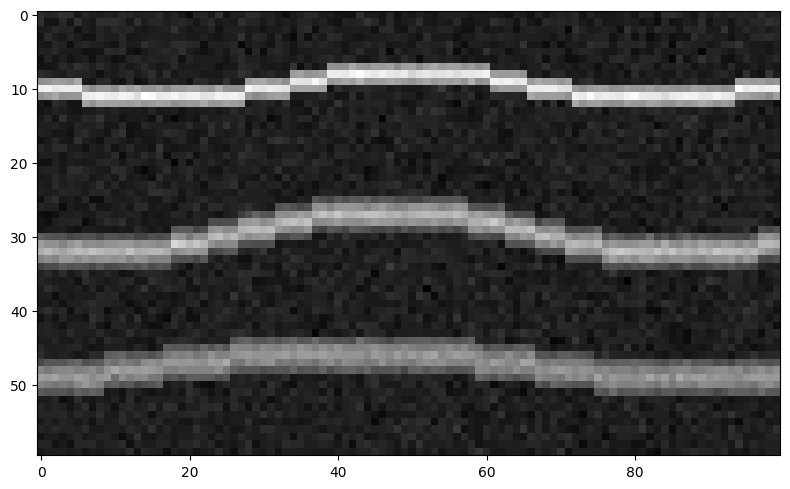

In [169]:
np.random.seed(0)
rows, cols = 60, 100
img = np.random.normal(0, 5, (rows, cols))
#img = (img - img.min() + 1e-6)

# Create smooth wiggly centerlines
y1 = rows // 6 + 2 * np.sin(np.linspace(0, 3*np.pi, cols))
y2 = rows // 2 + 3 * np.sin(np.linspace(0, 2.5*np.pi, cols) + 1)
y3 = (rows * 4) // 5 + 2 * np.cos(np.linspace(0, 2*np.pi, cols) + 0.5)

# Draw a line with intensity profile
def draw_line(img, y_center, thickness, peak_intensity):
    half = thickness // 2
    weights = np.exp(-0.5 * (np.arange(-half, half + 1) / (thickness / 3))**2)
    weights /= weights.max()  # normalize so center = 1
    for x_idx, y_c in enumerate(y_center.astype(int)):
        for offset, w in zip(range(-half, half + 1), weights):
            y = int(y_c + offset)
            if 0 <= y < img.shape[0]:
                img[y, x_idx] += peak_intensity * w

# Draw three bright non-crossing lines (3–5 px thick)
draw_line(img, y1, thickness=3, peak_intensity=120)
draw_line(img, y2, thickness=4, peak_intensity=90)
draw_line(img, y3, thickness=5, peak_intensity=70)

# Display
plt.figure(figsize=(8, 5))
plt.imshow(img, cmap='gray', origin='upper', aspect='auto')
plt.tight_layout()
plt.show()

In [171]:
#img

# Pre-processing

In [311]:
G=nx.DiGraph()
for r in range(len(img)):
    for c in range(len(img[r])):
        G.add_node("%s_%s"%(r,c),r=r,c=c,pixel=img[r][c],layer=c+1)
for u in G.nodes():
    for v in G.nodes():
        if G.nodes[v]["c"]==G.nodes[u]["c"]+1:
            if G.nodes[v]["r"] in [G.nodes[u]["r"],G.nodes[u]["r"]+1,G.nodes[u]["r"]-1]:
                #G.add_edge(u,v,cost=1/G.nodes[u]["pixel"])
                G.add_edge(u,v,cost=-G.nodes[u]["pixel"],cost2=-G.nodes[v]["pixel"])
nodes_from_source = []
nodes_to_sink = []
for v in G.nodes():
    if G.nodes[v]["c"]==0:
        nodes_from_source.append(v)
    if G.nodes[v]["c"]==len(img[0])-1:
        nodes_to_sink.append(v)
G.add_node("s",layer=0)
G.add_node("t",layer=len(img[0])+1)
for v in nodes_from_source:
    G.add_edge("s",v,cost=0,cost2=-G.nodes[v]["pixel"])
for v in nodes_to_sink:
    #G.add_edge(v,"t",cost=1/G.nodes[v]["pixel"])
    G.add_edge(v,"t",cost=-G.nodes[v]["pixel"],cost2=0)

In [423]:
#nx.draw(G,
#        pos=nx.multipartite_layout(G,subset_key="layer"),
#        node_size=1
#       )

# Optimization

## Unique line

In [424]:
L=nx.shortest_path(G,"s","t",weight="cost",method="bellman-ford")
nx.shortest_path_length(G,"s","t",weight="cost",method="bellman-ford")
#nx.shortest_path_length(G,"s","t",weight="cost2",method="bellman-ford")

-12066.215333933818

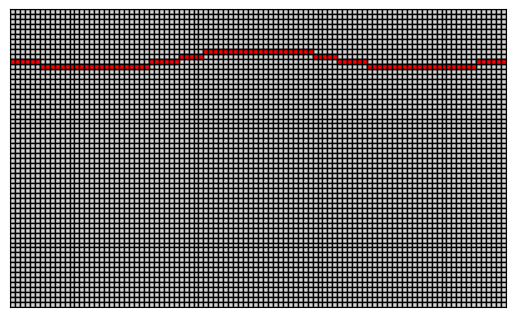

In [425]:
grid = img
highlight = [(G.nodes[v]["r"],G.nodes[v]["c"]) for v in G.nodes() if "r" in G.nodes[v] and "c" in G.nodes[v] and v in L]
rows, cols = grid.shape
#plt.figure(figsize=(8, 5))

for r in range(rows):
    for c in range(cols):
        plt.gca().add_patch(
            plt.Rectangle((c, r), 1, 1, facecolor="lightgrey", edgecolor="black")
        )

for (r, c) in highlight:
    plt.gca().add_patch(
        plt.Rectangle((c, r), 1, 1, facecolor="red", edgecolor="black")
    )

plt.xlim(0, cols)
plt.ylim(rows, 0)
plt.gca().set_aspect("equal")
plt.xticks([])
plt.yticks([])
plt.show()

## General case

In [392]:
shortest_paths = {}
shortest_paths_cost = {}
i=0
for v in G.successors("s"):
    i+=1
    shortest_paths[i]=nx.shortest_path(G,v,"t",weight="cost",method="bellman-ford")
    shortest_paths_cost[i]=-nx.shortest_path_length(G,v,"t",weight="cost",method="bellman-ford")
    
    for k in range(100):
        i+=1
        row = G.nodes[v]["r"]
        col= G.nodes[v]["c"]
        random_node = "%s_%s"%(row,random.choice([_ for _ in range(col+1,100)]))
        shortest_paths[i]=nx.shortest_path(G,v,random_node,weight="cost",method="bellman-ford")+nx.shortest_path(G,random_node,"t",weight="cost",method="bellman-ford")
        shortest_paths_cost[i]=-nx.shortest_path_length(G,v,random_node,weight="cost",method="bellman-ford")-nx.shortest_path_length(G,random_node,"t",weight="cost",method="bellman-ford")

for u in G.predecessors("t"):
    i+=1
    shortest_paths[i]=nx.shortest_path(G,"s",u,weight="cost2",method="bellman-ford")
    shortest_paths_cost[i]=-nx.shortest_path_length(G,"s",u,weight="cost2",method="bellman-ford")


In [426]:
#grid = img
#rows, cols = grid.shape
#for r in range(rows):
#    for c in range(cols):
#        plt.gca().add_patch(
#            plt.Rectangle((c, r), 1, 1, facecolor="lightgrey", edgecolor="black")
#        )
#for L in shortest_paths:
#    p=shortest_paths[L]
#    highlight = [(G.nodes[v]["r"],G.nodes[v]["c"]) for v in G.nodes() if "r" in G.nodes[v] and "c" in G.nodes[v] and v in p]
#    first_node=highlight[0]
#    for (r, c) in highlight:
#        plt.gca().add_patch(
#            plt.Rectangle((c, r), 1, 1, facecolor="red", edgecolor="black")
#        )
#plt.xlim(0, cols)
#plt.ylim(rows, 0)
#plt.gca().set_aspect("equal")
#plt.xticks([])
#plt.yticks([])
#plt.show()

In [427]:
# create problem
prob = pulp.LpProblem("lines", pulp.LpMaximize)

# define variables
x = pulp.LpVariable.dicts("x",shortest_paths,cat=pulp.LpBinary)

# maximize intensity
prob += pulp.lpSum(shortest_paths_cost[p]*x[p] for p in x)

# if needed, enforce a given number of lines
# prob += pulp.lpSum(x) == 3

# no crossings
for r in range(len(img)):
    for c in range(len(img[r])):
        l=[x[p] for p in x if "%s_%s"%(r,c) in shortest_paths[p]]
        if len(l)>0:
            prob += pulp.lpSum(x[p] for p in x if "%s_%s"%(r,c) in shortest_paths[p]) <= 1, "no_cross_cell_%s_%s"%(r,c)

In [398]:
#prob

In [428]:
prob.solve(solver=pulp.GUROBI_CMD())

1

In [429]:
pulp.value(prob.objective)

28128.103129243646

In [430]:
selected_shortest_paths = [p for p in shortest_paths if pulp.value(x[p])>0.9]
selected_shortest_paths_cost = [shortest_paths_cost[p] for p in x if pulp.value(x[p])>0.9]
selected_shortest_paths_cost

[12066.21533393382, 8985.004637895077, 7076.88315741475]

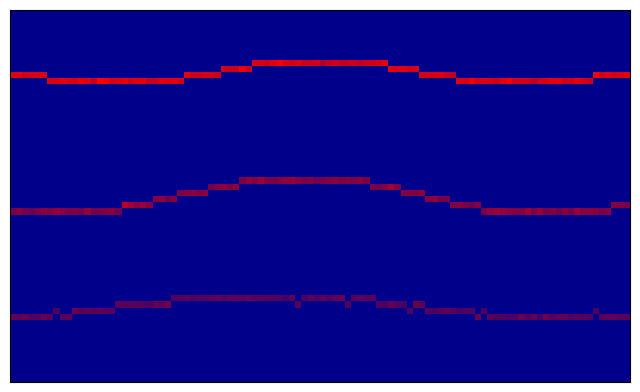

In [431]:
def normalize_to_alpha(value, min_val, max_val):
    # Clip value so it stays within min and max
    value = max(min_val, min(value, max_val))
    # Normalize to 0-1
    return (value - min_val) / (max_val - min_val)

grid = img
rows, cols = grid.shape
plt.figure(figsize=(8,8))
for r in range(rows):
    for c in range(cols):
        plt.gca().add_patch(
            plt.Rectangle((c, r), 1, 1, 
                          facecolor="darkblue", 
                          #edgecolor="black"
                         )
        )
for L in selected_shortest_paths:
    highlight = [(G.nodes[v]["r"],G.nodes[v]["c"]) for v in G.nodes() if "r" in G.nodes[v] and "c" in G.nodes[v] and v in shortest_paths[L]]
    for (r, c) in highlight:
        plt.gca().add_patch(
            plt.Rectangle((c, r), 1, 1, 
                          facecolor="red",
                          #edgecolor="black",
                          alpha=(normalize_to_alpha(img[r,c],img.min(),img.max()))**2
                         )
        )
plt.xlim(0, cols)
plt.ylim(rows, 0)
plt.gca().set_aspect("equal")
plt.xticks([])
plt.yticks([])
plt.show()